In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import argparse

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")

from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import my_data
from utils.dice_score import dice_loss
from evaluate import evaluate,random_cost,uncertainty_cost
from unet import UNet
from predict import predict_img
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
from torch.nn import functional as F

In [2]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [3]:
results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]

In [ ]:
from numpy.random import normal

In [8]:
run_folder = oj(config["PATHS"]["progress_results"], str('0984357990'))
args = pkl.load(open(oj(run_folder, "args.pkl"), "rb"))
results = pkl.load(open(oj(run_folder, "results.pkl"), "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\lauri\\Documents\\GitHub\\segmenter\\progress_files\\0984357990\\args.pkl'

In [ ]:
run_folder

In [7]:
results

{'file_name': '0984357990',
 'epochs': 2,
 'batch_size': 2,
 'cost_function': 'uncertainty_cost',
 'add_ratio': 0.5,
 'foldername': 'lno_halfHour',
 'poolname': 'lno_human',
 'experiment_name': '',
 'lr': 1e-05,
 'image_size': 128,
 'offset': 64,
 'seed': 42,
 'scale': 0.5,
 'val': 10,
 'amp': False,
 'add_step': 1,
 'bilinear': False,
 'classes': 6,
 'val_scores': [0.3869442045688629],
 'num_classes': 3}

In [8]:
a = normal(12.9, 2.2, 100000)
(a <(12)).mean()

0.34095

In [9]:
(6/30.5+10)

10.19672131147541

In [10]:
results.experiment_name.unique()

AttributeError: 'dict' object has no attribute 'experiment_name'

In [6]:
len(os.listdir(oj(config["DATASET"]["data_path"], "lno")))

2

In [7]:
# results = results[results.foldername == "lno_halfHour"]
results = results[results.experiment_name == results.experiment_name.unique()[0]]
results = results.reset_index()

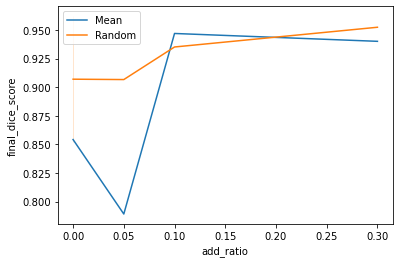

In [8]:
import seaborn as sns
for cost_function in results.cost_function.unique():
    sns.lineplot(data=results[results.cost_function == cost_function], x="add_ratio", y="final_dice_score", label =cost_function, )


In [9]:
results[['foldername',  'final_dice_score','cost_function', 'add_ratio',]].groupby(['cost_function','foldername','add_ratio' ]).mean()

final_dice_score
cost_function foldername   add_ratio                  
Mean          lno_halfHour 0.00                   0.85
                           0.05                   0.79
                           0.10                   0.95
                           0.30                   0.94
Random        lno          0.00                   0.96
              lno_halfHour 0.00                   0.85
                           0.05                   0.91
                           0.10                   0.94
                           0.30                   0.95

In [24]:
results = results[results.foldername == 'lno_hour']
results = results.reset_index()

In [25]:
best_idx =results.best_val_score.argmax()


ValueError: attempt to get argmax of an empty sequence

In [ ]:
net = UNet(1, results.num_classes[best_idx], bilinear = results.bilinear[best_idx]).to(device)
# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[best_idx]+".pt")))
net = net.to(device).eval()

In [31]:
x,y,num_classes, _ = my_data.load_layer_data(oj(data_path, 'lno_halfHour'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]



In [32]:
(y == 255).mean()

0.5873926639556885

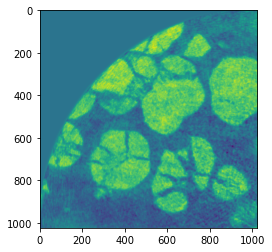

In [25]:
plt.imshow(x[2][0])

In [23]:
np.unique(y[2])

array([  0,   1,   2, 255], dtype=uint8)

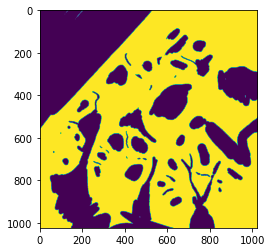

In [28]:
plt.imshow(y[2] == 255)

In [29]:
(y == 255).mean()

0.4973133087158203

In [10]:

(y ==2).mean()

0.07693319320678711

In [ ]:
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * 0.1 / 100), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs
init_train_idxs = all_train_idxs

In [29]:
x_pool_all = my_data.make_dataset_single(
    x[init_train_idxs],
    img_size=128,
    offset=128,
)[0]

In [28]:
x_pool_all.shape

(8775, 1, 128, 128)